In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sns.set_theme(
    style="whitegrid", 
    font_scale=1.1
)

# 📂 Dataset Description

**File:** `train.csv`  
**Size:** 733,271 rows (+1 header row) and 112 columns  

---

### 🧱 Column Structure
- **Column 1 — `ID_FIRM`**: company identifier  
- **Columns 2–111**: financial statement indicators for two dates — *01.01.2017* and *01.01.2018*  
- **Column 112 — `BANKR`**: bankruptcy status of the company in 2018  
  - `0` — not bankrupt  
  - `1` — bankrupt  

---

### 🧾 Encoding of Financial Statement Lines
Financial statement indicators are encoded in the following format:

### P[line_number]_[B|E]
**where:**  
- **`line_number`** — a four-digit number corresponding to a line from Form 1 or Form 2 of the financial statement  
- **`B`** (*begin*) — value as of 01.01.2017  
- **`E`** (*end*) — value as of 01.01.2018  

In [2]:
code_to_name = {

    # --- Форма 1: АКТИВ ---
    1110: "Нематериальные активы",
    1120: "Результаты исследований и разработок",
    1130: "Нематериальные поисковые активы",
    1140: "Материальные поисковые активы",
    1150: "Основные средства",
    1160: "Доходные вложения в материальные ценности",
    1170: "Финансовые вложения",
    1180: "Отложенные налоговые активы",
    1190: "Прочие внеоборотные активы",
    1100: "Итого по разделу I (Внеоборотные активы)",

    # Оборотные активы
    1210: "Запасы",
    1220: "НДС по приобретённым ценностям",
    1230: "Дебиторская задолженность",
    1240: "Финансовые вложения (кроме денежных эквивалентов)",
    1250: "Денежные средства и денежные эквиваленты",
    1260: "Прочие оборотные активы",
    1200: "Итого по разделу II (Оборотные активы)",

    1600: "Баланс (актив)",

    # --- Форма 1: ПАССИВ ---
    # Капитал и резервы
    1310: "Уставный капитал",
    1320: "Собственные акции, выкупленные у акционеров",
    1340: "Переоценка внеоборотных активов",
    1350: "Добавочный капитал (без переоценки)",
    1360: "Резервный капитал",
    1370: "Нераспределённая прибыль (непокрытый убыток)",
    1300: "Итого по разделу III (Капитал и резервы)",

    # Долгосрочные обязательства
    1410: "Долгосрочные заемные средства",
    1420: "Отложенные налоговые обязательства",
    1430: "Оценочные обязательства",
    1450: "Прочие обязательства",
    1400: "Итого по разделу IV (Долгосрочные обязательства)",

    # Краткосрочные обязательства
    1510: "Краткосрочные заемные средства",
    1520: "Кредиторская задолженность",
    1530: "Доходы будущих периодов",
    1540: "Оценочные обязательства",
    1550: "Прочие обязательства",
    1500: "Итого по разделу V (Краткосрочные обязательства)",

    1700: "Баланс (пассив)",

    # --- Форма 2: Отчёт о фин. результатах ---
    2110: "Выручка",
    2120: "Себестоимость продаж",
    2100: "Валовая прибыль (убыток)",
    2210: "Коммерческие расходы",
    2220: "Управленческие расходы",
    2200: "Прибыль (убыток) от продаж",
    2310: "Доходы от участия в других организациях",
    2320: "Проценты к получению",
    2330: "Проценты к уплате",
    2340: "Прочие доходы",
    2350: "Прочие расходы",
    2300: "Прибыль (убыток) до налогообложения",
    2410: "Текущий налог на прибыль",
    2421: "Постоянные налоговые обязательства (активы)",
    2430: "Изменение отложенных налоговых обязательств",
    2450: "Изменение отложенных налоговых активов",
    2460: "Прочее",
    2400: "Чистая прибыль (убыток)",
}


# Data loading

In [3]:
data = pd.read_csv('../data/train.csv')
data.head()

,ID_FIRM,P1110_B,P1110_E,P1120_B,P1120_E,P1130_B,P1130_E,P1140_B,P1140_E,P1150_B,...,P2421_E,P2430_B,P2430_E,P2450_B,P2450_E,P2460_B,P2460_E,P2400_B,P2400_E,BANKR
0,1,8,7,0,0,0,0,0,0,402,...,161,0,0,0,0,0,0,1561,621,0
1,2,0,0,3318,3318,0,0,0,0,208809,...,0,0,0,0,0,0,8551,-15296,-16123,0
2,3,0,0,0,0,0,0,0,0,237,...,0,0,0,0,0,6,0,-2166,-1375,0
3,4,0,0,0,0,0,0,0,0,15428,...,-55,0,22,0,4,0,0,-3390,502,0
4,5,0,0,0,0,0,0,0,0,340249,...,-895,0,11,0,0,105,0,26131,6100,0


# General data overview

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733271 entries, 0 to 733270
Columns: 112 entries, ID_FIRM to BANKR
dtypes: float64(19), int64(93)
memory usage: 626.6 MB


In [5]:
data.shape

(733271, 112)

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID_FIRM,733271.0,366636.000000,2.116772e+05,1.0,183318.5,366636.0,549953.5,733271.0
P1110_B,733271.0,2152.351230,8.918254e+05,0.0,0.0,0.0,0.0,744775581.0
P1110_E,733271.0,2794.102590,1.015836e+06,0.0,0.0,0.0,0.0,744775581.0
P1120_B,733271.0,264.972715,5.095348e+04,0.0,0.0,0.0,0.0,36803482.0
P1120_E,733271.0,305.079855,5.624770e+04,0.0,0.0,0.0,0.0,35165672.0
...,...,...,...,...,...,...,...,...
P2460_B,733271.0,408.792959,4.299592e+04,0.0,0.0,0.0,0.0,30573067.0
P2460_E,733271.0,475.910365,5.457941e+04,0.0,0.0,0.0,0.0,28756831.0
P2400_B,733271.0,9013.327554,1.147772e+06,-600518697.0,-7.0,0.0,550.0,493876141.0
P2400_E,733271.0,6080.731120,8.452196e+05,-120058575.0,-34.0,6.0,722.0,301047661.0


### Note that some features are sums of other ones, that is, a linear combination


# Missing values analysis

In [7]:
data.isna().sum().sum()

0

### There is no Na in dataframe. But gapes are marked as nulls.

#### ROWS:

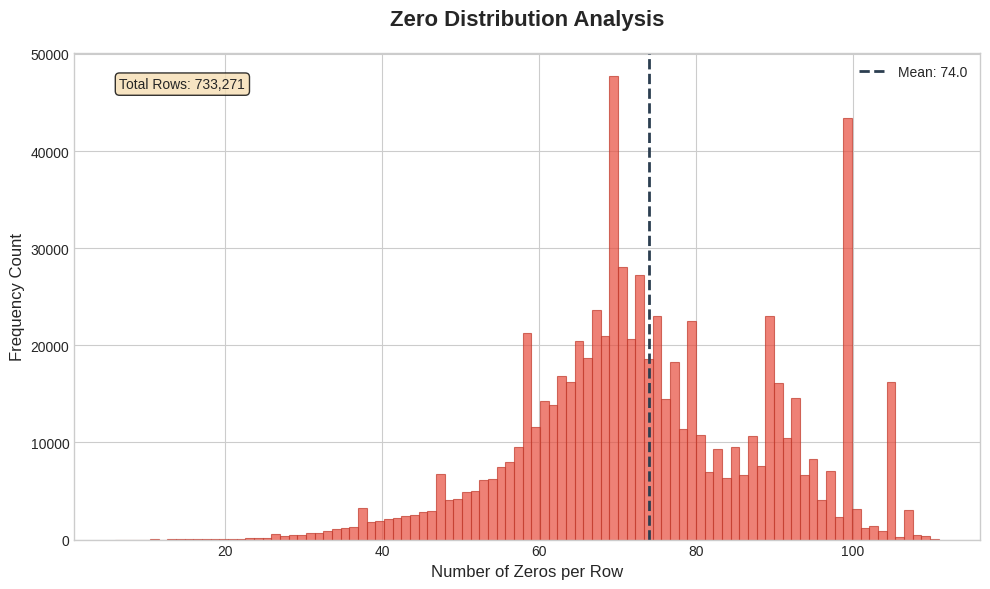

In [8]:
zero_counts_rows = (data == 0).sum(axis=1)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

n, bins, patches = ax.hist(zero_counts_rows, bins=95, alpha=0.7, color='#e74c3c', 
                          edgecolor='#c0392b', linewidth=0.8)

ax.set_title("Zero Distribution Analysis", fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel("Number of Zeros per Row", fontsize=12)
ax.set_ylabel("Frequency Count", fontsize=12)
mean_zeros = zero_counts_rows.mean()
ax.axvline(mean_zeros, color='#2c3e50', linestyle='--', linewidth=2, 
           label=f'Mean: {mean_zeros:.1f}')

ax.text(0.05, 0.95, f'Total Rows: {len(data):,}', transform=ax.transAxes,
        fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax.legend()
plt.tight_layout()
plt.show()

#### COLUMNS:

In [9]:
zero_counts_cols = data.apply(lambda col: (col==0).sum())

In [10]:
zero_counts_cols.sort_values(ascending=False)

P1140_E    732657
P1140_B    732647
P1430_B    732408
P1430_E    732327
P1130_B    732178
            ...  
P1300_E     71166
P1200_E     26519
P1600_E     16215
P1700_E     14263
ID_FIRM         0
Length: 112, dtype: int64

### The dataset contains a substantial amount of missing values, and for several features the proportion of missing data is very high. This has to be explicitly addressed during preprocessing: some features may need to be dropped, while for others robust imputation strategies and/or additional “missingness” flags should be introduced to avoid biasing the model.

# Target variable analysis

In [133]:
X = data.drop(['BANKR', 'ID_FIRM'], axis=1)
y = data.BANKR

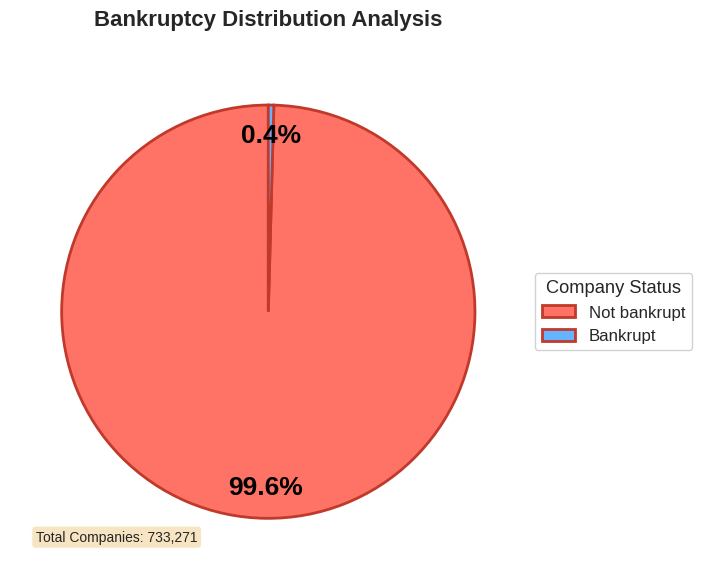

In [165]:
df_bankr = data.BANKR.value_counts()
df_bankr.index = ['Not bankrupt', 'Bankrupt']

plt.style.use('seaborn-v0_8-whitegrid')
colors = ['#ff7366', '#66b3ff']

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = ax.pie(
    df_bankr,
    colors=colors,
    startangle=90,
    wedgeprops=dict(edgecolor='#c0392b', linewidth=2),
    autopct='%1.1f%%',
    pctdistance=0.85,
    textprops={'fontsize': 19, 'color': 'black', 'fontweight': 'bold'}
)

ax.set_title("Bankruptcy Distribution Analysis", fontsize=16, fontweight='bold', pad=20)

ax.legend(wedges, df_bankr.index,
          title="Company Status",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          frameon=True,
          framealpha=0.9
         )

total = df_bankr.sum()
ax.text(0.05, 0.05, f'Total Companies: {total:,}', transform=ax.transAxes,
        fontsize=10, verticalalignment='bottom', 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

### Note that there is a strong imbalance between the classes of the target feature. In the modeling stage, this imbalance has to be taken into account by using appropriate metrics and applying imbalance-handling techniques such as class weights.

# Distribution analysis

In [62]:
rand_col_idx = random.sample(range(110), 15)
rand_columns = data.columns[rand_col_idx]
rand_columns

Index(['P2340_E', 'P1430_B', 'P1320_E', 'P1450_E', 'P1530_B', 'P1420_B',
       'P1100_B', 'P1190_B', 'P1600_B', 'P2300_E', 'P1520_B', 'P1200_B',
       'ID_FIRM', 'P1300_B', 'P2430_E'],
      dtype='object')

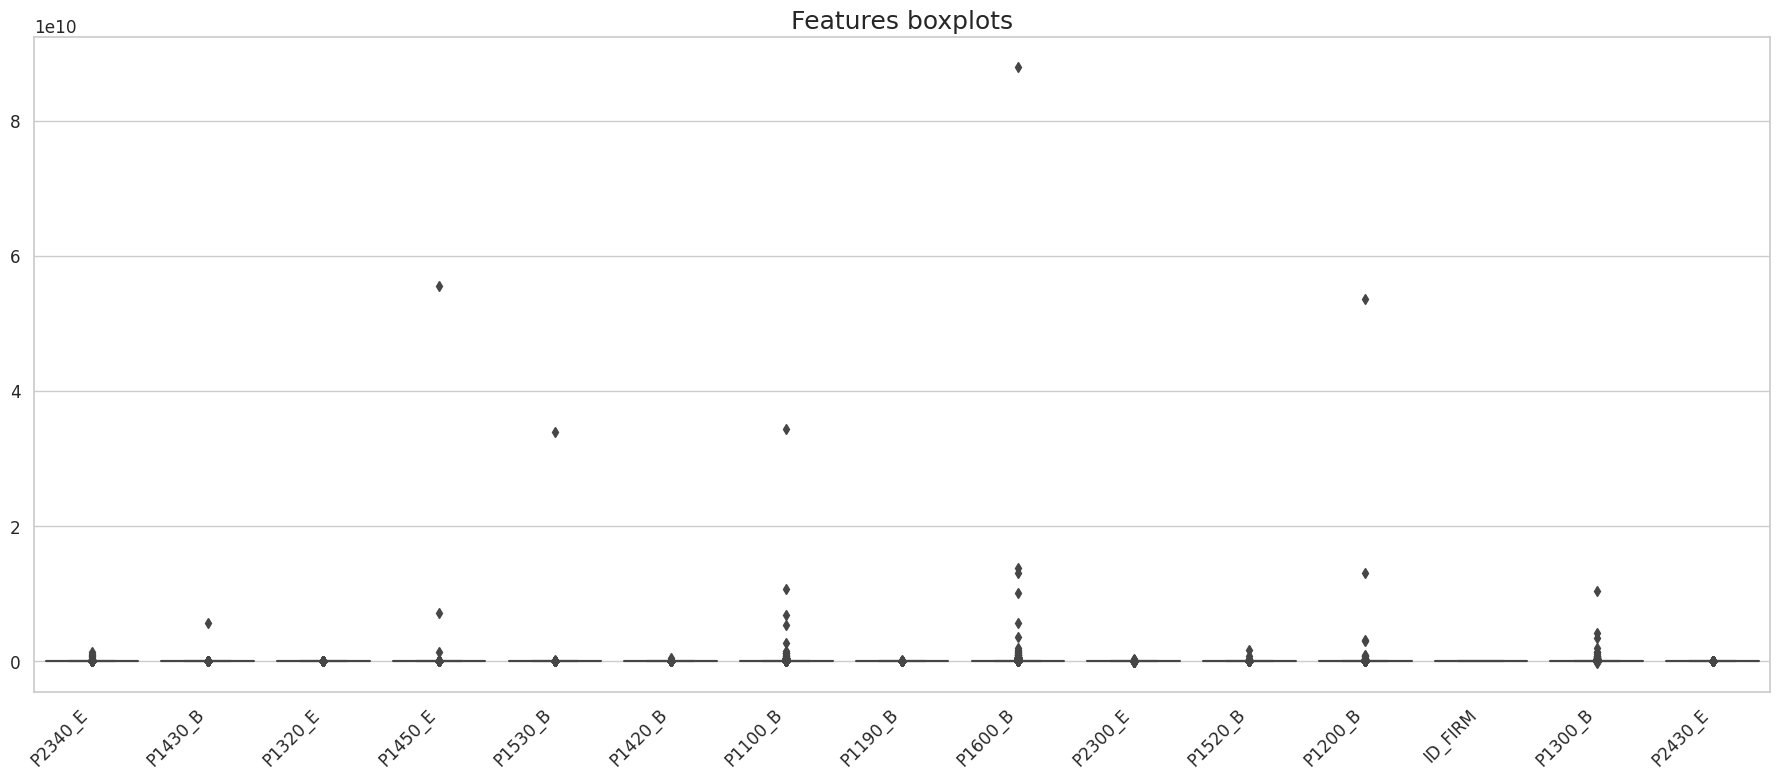

In [64]:
plt.figure(figsize=(18, 8))
sns.boxplot(
    data=data[rand_columns]
)
plt.xticks(rotation=45, ha="right")
plt.title("Features boxplots", fontsize=18)
plt.tight_layout()
plt.show()


### We can see, that some features contain very large outliers, which may significantly affect the scale and summary statistics


# Correlation analysis

In [12]:
corr_matrix = data.corr()

<Axes: title={'center': 'Features correlation matrix'}>

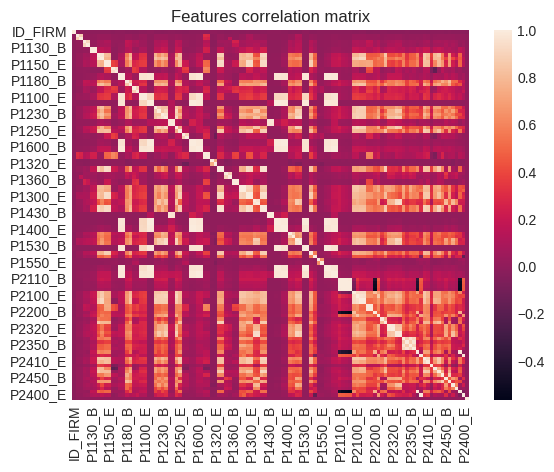

In [13]:
plt.title('Features correlation matrix')
sns.heatmap(corr_matrix)

### Some features correlate at a level higher than 0.9 (multicollinearity). It will be a problem for some non-tree based models

# Correlation with target feature

In [80]:
corr_with_target = data.corr()['BANKR'].drop('BANKR').drop('ID_FIRM')

In [117]:
corr_with_target_df = pd.DataFrame({'feature' : X.columns, 'correlation' : corr_with_target})
corr_with_target_df = corr_with_target_df.sort_values(by='correlation')

In [122]:
list(corr_with_target)

[-4.4258684124579105e-05,
 -8.869987444817251e-05,
 -0.00012582737085052145,
 -0.00017616055218678867,
 -0.00011259168582379244,
 -0.00011775593349546962,
 -0.00019774834962043837,
 -0.0002122428196791477,
 4.079407807318211e-05,
 -6.72663034048019e-05,
 0.00014575300016265926,
 8.82170492749113e-05,
 -8.744268002818076e-05,
 -0.00010445618683232215,
 0.0028633863465731667,
 0.0028333203526083903,
 0.0018209756445751598,
 0.0017809560801182248,
 -4.783322259149126e-05,
 -8.904307974699878e-05,
 -8.664589703037333e-06,
 -2.977169210787122e-05,
 0.001634863072261371,
 0.0016004242381149373,
 0.004649776233588843,
 0.0031310802709195304,
 0.0004175116838733922,
 0.00017928034843302614,
 -0.00033803802075839606,
 -0.0006121704880267878,
 0.006108594905557316,
 0.006880547498392214,
 0.00026155877013114755,
 0.0001886602915804593,
 0.0001396794161456605,
 7.808404473650376e-05,
 9.925436549793352e-06,
 -2.0769188293125016e-05,
 -0.0001299226633628476,
 -0.0006796286972257225,
 -7.0502654642

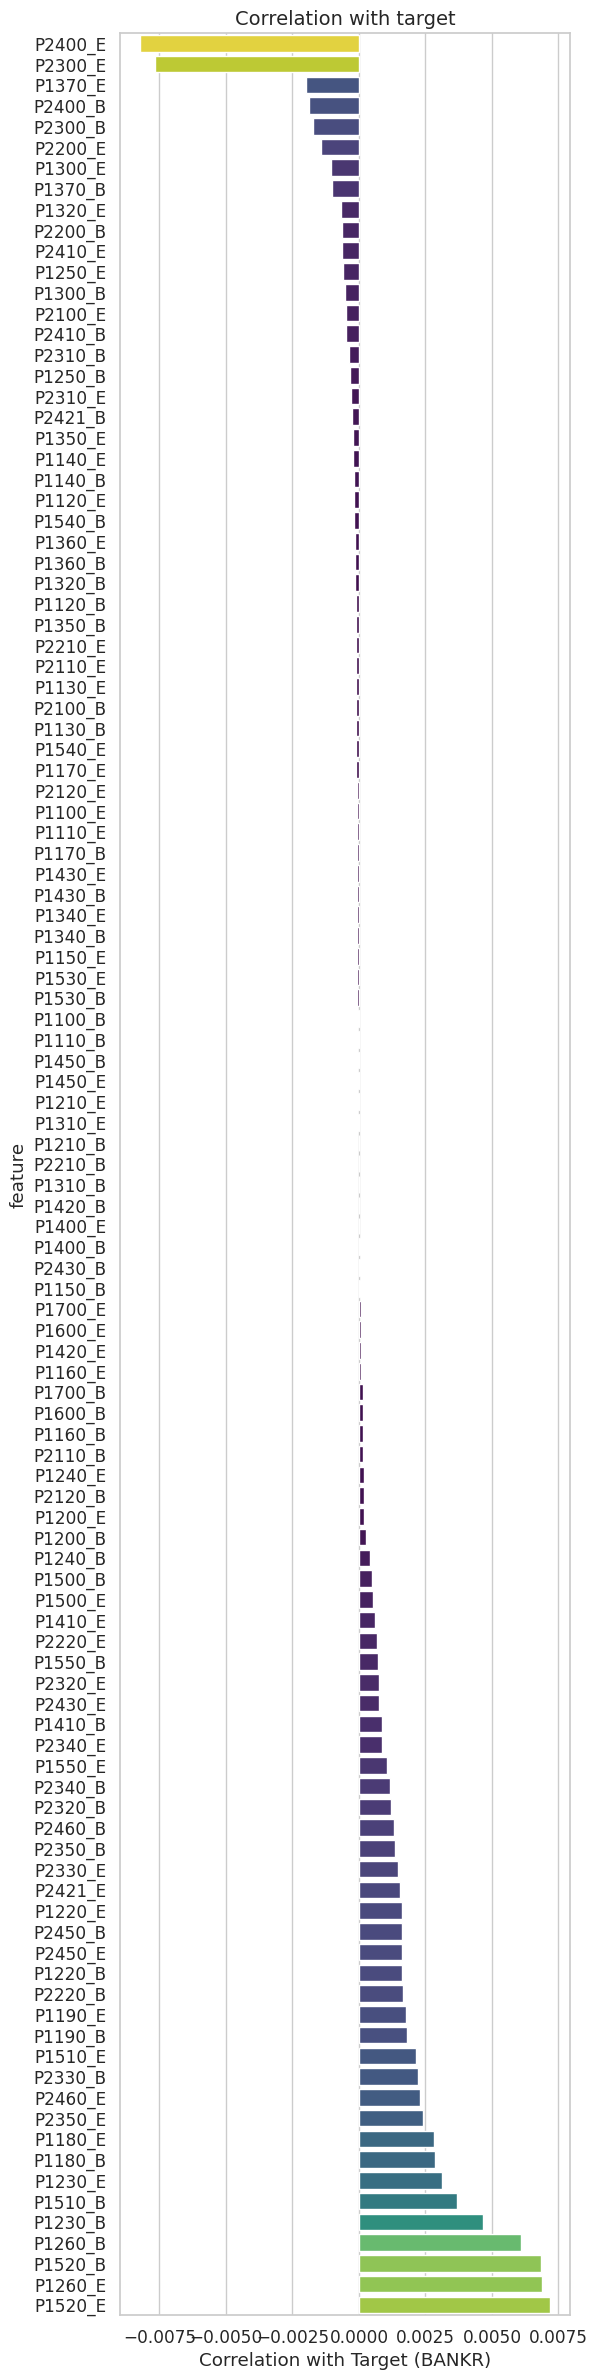

In [119]:
values = corr_with_target_df.correlation
abs_values = np.abs(values)

norm = mcolors.Normalize(vmin=abs_values.min(), vmax=abs_values.max())

cmap = plt.colormaps.get_cmap("viridis")

colors = [cmap(norm(v)) for v in abs_values]

plt.figure(figsize=(6, 24))
sns.barplot(
    data=corr_with_target_df,
    y='feature',
    x='correlation',
    palette=colors
)
plt.title("Correlation with target", fontsize=14)
plt.xlabel("Correlation with Target (BANKR)")
plt.tight_layout()

plt.show()


### We see that there isn't correlation more than 0.008 (very small value)
### So no single feature has linear relationship with target. Bankruptcy is not driven by any single indicator, but rather by complex combinations of features

# Feature importances

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
RF_model = RandomForestClassifier()

In [34]:
X.iloc[:100]

,P1110_B,P1110_E,P1120_B,P1120_E,P1130_B,P1130_E,P1140_B,P1140_E,P1150_B,P1150_E,...,P2421_B,P2421_E,P2430_B,P2430_E,P2450_B,P2450_E,P2460_B,P2460_E,P2400_B,P2400_E
0,8,7,0,0,0,0,0,0,402,398.0,...,345,161,0,0,0,0,0,0,1561,621
1,0,0,3318,3318,0,0,0,0,208809,205131.0,...,0,0,0,0,0,0,0,8551,-15296,-16123
2,0,0,0,0,0,0,0,0,237,237.0,...,0,0,0,0,0,0,6,0,-2166,-1375
3,0,0,0,0,0,0,0,0,15428,15364.0,...,0,-55,0,22,0,4,0,0,-3390,502
4,0,0,0,0,0,0,0,0,340249,348946.0,...,-1045,-895,0,11,0,0,105,0,26131,6100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,5422,4360.0,...,-162,-61,0,0,2,2295,3219,0,2164,-13236
96,0,0,0,0,0,0,0,0,432,596.0,...,0,0,0,0,0,0,0,0,1723,421
97,2498,2498,0,0,0,0,0,0,112011,107223.0,...,-8796,-86386,40569,2701,5229,4807,2280,2042,-31939,65676
98,0,0,0,0,0,0,0,0,10230,8121.0,...,130,105,20,21,0,0,0,0,-2268,4480


In [35]:
RF_model.fit(X.iloc[:100000], y[:100000])

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [50]:
importances = np.array(sorted(list(zip(X.columns,RF_model.feature_importances_)), key=lambda x: -x[1]))

In [65]:
df_imp = pd.DataFrame(importances)

In [84]:
df_imp.columns = ['feature', 'importance']

In [89]:
df_imp['importance'] = pd.to_numeric(df_imp['importance'])

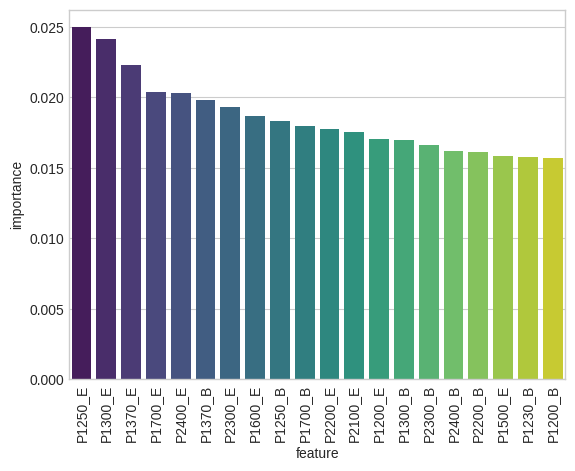

In [34]:
sns.barplot(data=df_imp.iloc[:20], x='feature', y='importance', palette='viridis')
plt.xticks(rotation=90);


### According to the Random Forest model, "Cенежные средства и денежные эквиваленты" is the most influential feature. However, the feature importance scores decrease very smoothly, so there is no single dominant feature and the model relies on a combination of many variables.

# PCA

In [136]:
X_scaled = StandardScaler().fit_transform(X)

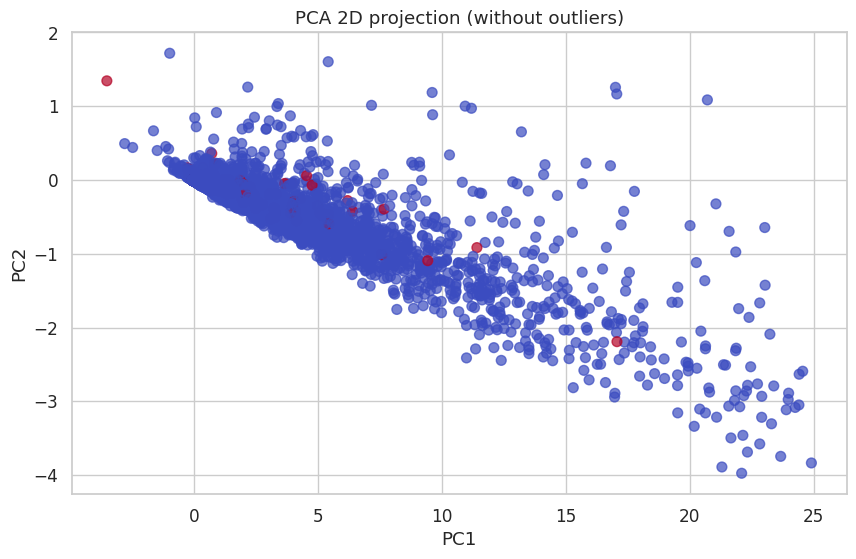

Explained variance by first 2 PCs: 0.50578840612286


In [164]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

X_pca_without_outliers = []
y_without_outliers = []
for i, j in zip(X_pca, y):
    if -5<i[0]<25 and -4<i[1]<2:
        X_pca_without_outliers.append(i)
        y_without_outliers.append(j)
X_pca_without_outliers = np.array(X_pca_without_outliers)
y_without_outliers = np.array(y_without_outliers)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca_without_outliers[:, 0],
            X_pca_without_outliers[:, 1], 
            c=y_without_outliers, 
            alpha=0.7, 
            s=50,
           cmap='coolwarm')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA 2D projection (without outliers)')
plt.show()

print("Explained variance by first 2 PCs:",
      pca.explained_variance_ratio_.sum())

### The two components account for a significant portion of the variance. But there is no linear separabillity, so further solution will require nonlinear methods and possibly feature engineering

# EDA Summary

### Overall, the EDA shows that the dataset contains many correlated financial indicators, including some near-duplicate features and several columns with a high proportion of missing values. 
### The target variable is strongly imbalanced, and individual features have almost no linear relationship with bankruptcy (correlations below ±0.008). 
### Outliers and multicollinearity are present and should be handled during preprocessing. 
### PCA confirms the absence of linear separability, and Random Forest feature importances indicate that the model relies on many features rather than a single dominant one. 
### These observations suggest that nonlinear models and additional feature engineering will be necessary for effective prediction.
